In [1]:
# 1. Các thư viện cần thiết
import numpy as np
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error,mean_squared_error

In [2]:
# 2. Đọc file dữ liệu chứng khoán AAPL và chia train test validate theo tỉ lệ 7:1:2
data = pd.read_csv('/content/USDT-USD.csv')
df = data[['Close']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

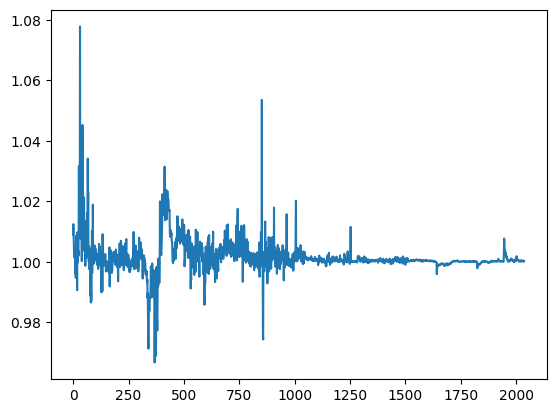

In [3]:
pyplot.plot(df)
pyplot.show()

In [4]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 21.1 MB/s eta 0:00:00


In [5]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-11333.212, Time=4.87 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-10926.691, Time=0.30 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-11146.529, Time=0.40 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-11281.695, Time=1.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-10928.689, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-11314.353, Time=0.85 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-11334.828, Time=2.79 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-11318.996, Time=0.74 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-11220.422, Time=0.60 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-11290.123, Time=4.54 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-11272.195, Time=3.52 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-11312.726, Time=6.60 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-11330.394, Time=1.04 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 27.728 sec

ARIMA(order=(2, 1, 1), scoring_args={}, suppress_warnings=True)

In [6]:
# 4. Quá trình testing 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
y_pred = model.predict(n_periods=len(y_test))

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])
y_pred_val =  model.predict(n_periods=len(y_val))

In [7]:
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[1.00024464 1.00021977 1.00019286 1.00017601 1.00016186 1.0001491
 1.00013689 1.00012492 1.00011305 1.00010123 1.00008942 1.00007763
 1.00006583 1.00005404 1.00004225 1.00003046 1.00001867 1.00000688
 0.99999509 0.9999833  0.99997151 0.99995972 0.99994793 0.99993614
 0.99992435 0.99991256 0.99990077 0.99988897 0.99987718 0.99986539]


In [8]:
# 7. Đánh giá độ chính xác validate, test
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation RMSE: 0.0019281938040971007
Testing RMSE: 0.002561408561634798


In [9]:
val_mape = mean_absolute_percentage_error(y_val, y_pred_val)
test_mape = mean_absolute_percentage_error(y_test, y_pred)
print("Validation MAPE:", val_mape)
print("Test MAPE:", test_mape)

Validation MAPE: 0.0014686301707348749
Test MAPE: 0.0022471749735503616


In [10]:
val_mase = mean_squared_error(y_val, y_pred_val)
test_mse = mean_squared_error(y_test, y_pred)
print("Validation MSE:", val_mase)
print("Test MSE:", test_mse)

Validation MSE: 3.7179313461584485e-06
Test MSE: 6.560813819616045e-06


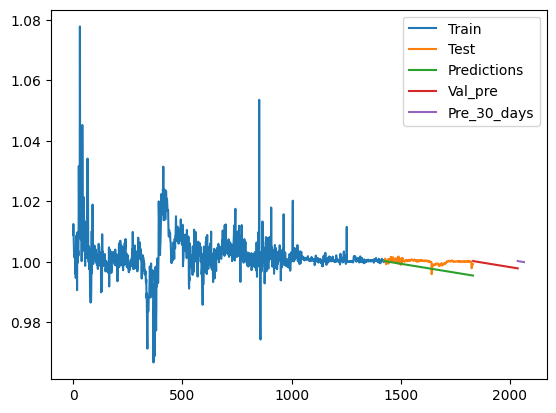

In [11]:
# 9.Vẽ hình
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Val_pre','Pre_30_days'])
plt.show()